In [261]:
import os
from PIL import Image
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import xml.etree.ElementTree as ET
import tensorflow as tf
import keras
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Flatten
from tensorflow.keras.utils import img_to_array, load_img
from keras.utils import to_categorical
from timeit import default_timer as timer

In [262]:
# Path to the directory containing images and annotations
data_path = '/Users/caitlinchen/Desktop/cmps4020/kaggle2'

#Create Images and Labels folders
image_folder = os.path.join(data_path, 'images')
labels_folder = os.path.join(data_path, 'annotations')

# Lists to store features (X) and labels (y)
X = []
y = []

for image_file in os.listdir(image_folder):
    # Load Image
    image_path = os.path.join(image_folder, image_file)
    image = Image.open(image_path).convert('RGB')
    #image = load_img(image_path, target_size=(224, 224))
    image = image.resize((224, 224))
    image_array = img_to_array(image)

    X.append(image_array)

    # Extract corresponding label from the XML annotation
    label_file = os.path.join(labels_folder, image_file.replace('.png', '.xml'))
    tree = ET.parse(label_file)
    root = tree.getroot()
    class_label = root.find('.//object/name').text
    if class_label == 'speedlimit':
        class_label = 0
    elif class_label == 'stop':
        class_label = 1
    elif class_label == 'crosswalk':
        class_label = 2
    elif class_label == 'trafficlight':
        class_label = 3
    y.append(class_label)

# Converting lists to numpy arrays
X = np.array(X)
y = np.array(y)

pre_processed_X = []
for image in X:
  pre_processed_image = keras.applications.vgg16.preprocess_input(image)
  pre_processed_X.append(pre_processed_image)

encoded_labels = to_categorical(y,4)

In [263]:
decode_predictions = tf.keras.applications.vgg16.decode_predictions
def get_imagenet_label(probs):
  return decode_predictions(probs, top=1)[0][0]

In [264]:
#load pre-trained model
model = VGG16(weights='imagenet', include_top=False, classes = 4, input_shape=(224, 224, 3))
x = model.output
x = GlobalAveragePooling2D()(x)  # Global average pooling layer
x = Dense(1024, activation='relu')(x)  # Fully connected layer
predictions = Dense(4, activation='softmax')(x)  # Output layer

model = Model(inputs=model.input, outputs=predictions)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [265]:
#visualize perturbed images
image = pre_processed_X[1]/50
print(image.shape)
print(model.input_shape)
print()

(224, 224, 3)
(None, 224, 224, 3)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


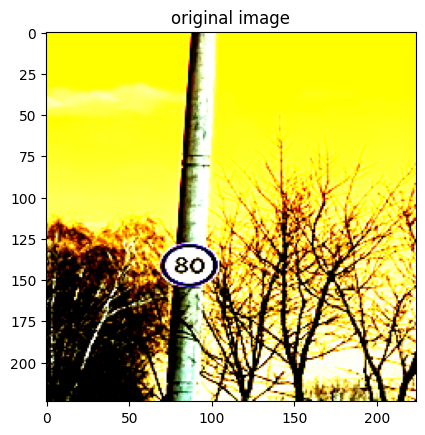

In [266]:
#image1 = Image.open('/Users/caitlinchen/Desktop/cmps4020/kaggle2/images/road107.png')
plt.figure()
plt.imshow(image)  # To change [-1, 1] to [0,1]
plt.title('original image')
plt.show()

In [267]:
#create adversarial image

loss_object = tf.keras.losses.CategoricalCrossentropy()

def create_adversarial_pattern(input_image, input_label):
    with tf.GradientTape() as tape:
        tape.watch(input_image)
        prediction = model(input_image)
        loss = loss_object(input_label, prediction)

    gradient = tape.gradient(loss, input_image)
    signed_grad = tf.sign(gradient)
    print("prediction: ", prediction)
    return signed_grad

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step
LABEL:  tf.Tensor([[0. 1. 0. 0.]], shape=(1, 4), dtype=float32)
IMG:  tf.Tensor(
[[[[ 2.6012201   1.4844201  -0.1936    ]
   [ 2.62122     1.46442    -0.1736    ]
   [ 2.6012201   1.44442    -0.1936    ]
   ...
   [ 2.54122     1.42442    -0.2336    ]
   [ 2.54122     1.42442    -0.2336    ]
   [ 2.54122     1.42442    -0.2336    ]]

  [[ 2.6012201   1.46442    -0.1736    ]
   [ 2.62122     1.46442    -0.1736    ]
   [ 2.62122     1.46442    -0.1736    ]
   ...
   [ 2.54122     1.42442    -0.2336    ]
   [ 2.54122     1.42442    -0.2336    ]
   [ 2.54122     1.42442    -0.2336    ]]

  [[ 2.5612202   1.4844201  -0.1736    ]
   [ 2.5812201   1.46442    -0.1736    ]
   [ 2.5812201   1.46442    -0.1736    ]
   ...
   [ 2.54122     1.42442    -0.2336    ]
   [ 2.54122     1.42442    -0.2336    ]
   [ 2.54122     1.42442    -0.2336    ]]

  ...

  [[-0.33878005 -0.43558    -0.6536    ]
   [-0.47878006 -0.55557996 -0.7736    ]
   [-0.15878005 -0.2555799

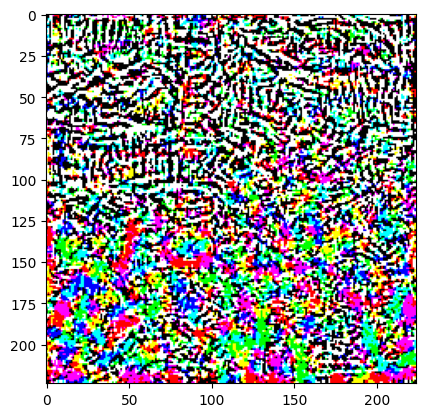

In [268]:
image = np.expand_dims(image, axis=0)
image_probs = model.predict(image)
image = tf.convert_to_tensor(image)
index = 1
label = tf.one_hot(index, image_probs.shape[-1])
label = tf.reshape(label, (1, image_probs.shape[-1]))
print("LABEL: ", label)
print("IMG: ", image)

perturbation = create_adversarial_pattern(image, label)
plt.imshow(perturbation[0] * 0.5 + 0.5);

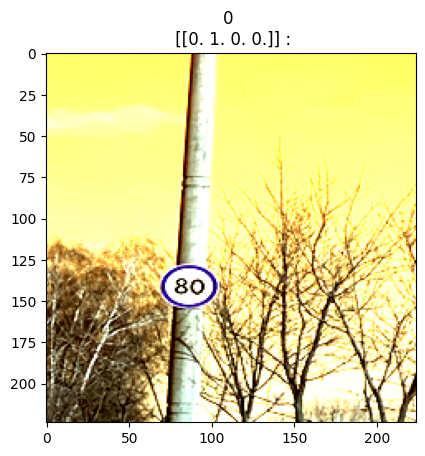

In [269]:
def display_images(image, description):
  plt.figure()
  plt.imshow(image[0]*0.5+0.5)
  plt.title('{} \n {} :'.format(description, label))
  plt.show()

eps = 0
adv_x = image + eps*perturbation
adv_x = tf.clip_by_value(adv_x, -1, 1)
display_images(adv_x, eps)


In [270]:
# Spliting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
num_classes = len(np.unique(y_train))
y_train_encoded = to_categorical(y_train, num_classes)
y_test_encoded = to_categorical(y_test, num_classes)

In [271]:
start = timer()
print("Starting Timer")
accuracy = model.evaluate(X_test, y_test_encoded)[1]
end = timer()
print("Time to Run: ", (end - start))
print(f"Accuracy: {accuracy}")

Starting Timer
6/6 ━━━━━━━━━━━━━━━━━━━━ 28s 4s/step - accuracy: 0.0416 - loss: 4.6039
Time to Run:  28.347363991000748
Accuracy: 0.05113636329770088


In [272]:
start = timer()
print("Starting Timer")
model.fit(X_train, y_train_encoded, epochs=10, batch_size=32)
end = timer()
print("Time to Run: ", (end - start))

Starting Timer
Epoch 1/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 406s 18s/step - accuracy: 0.6281 - loss: 5.7094
Epoch 2/10
 6/22 ━━━━━━━━━━━━━━━━━━━━ 4:36 17s/step - accuracy: 0.7627 - loss: 0.8887

KeyboardInterrupt: 

In [ ]:
start = timer()
print("Starting Timer")
accuracy = model.evaluate(X_test, y_test_encoded)[1]
end = timer()
print("Time to Run: ", (end - start))
print(f"Accuracy: {accuracy}")

'start = timer()\nprint("Starting Timer")\naccuracy = model.evaluate(X_test, y_test_encoded)[1]\nend = timer()\nprint("Time to Run: ", (end - start))\nprint(f"Accuracy: {accuracy}")'